In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_LPC_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 127 × 19304
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
COPs,3,6
MFOLs,5,5
MOL_A,3,3
MOL_B,5,9
MOL_C,5,8
MOL_D,5,9
MOL_E,4,9
MOL_F,3,9
MOL_G,3,3


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['OPCs'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (14, 19304)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Pandey et al. 2022': 'Pandey'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-1-0-0-0-0-0-0-0-0-0-0,(this study),ctrl,OPCs,1,ctrl_1,LPC_Saline_2,Adams,114188,11.645601,1,OPCs_LPC_Saline_2
donor_ctrl_2_0-1-0-0-0-0-0-0-0-0-0-0,(this study),ctrl,OPCs,2,ctrl_2,LPC_Saline_1,Adams,208937,12.249788,2,OPCs_LPC_Saline_1
donor_ctrl_3_0-1-0-0-0-0-0-0-0-0-0-0,Pandey et al. 2022,ctrl,OPCs,3,ctrl_3,LPC_ctrl_3,Pandey,441285,12.997446,3,OPCs_LPC_ctrl_3
donor_ctrl_4_0-1-0-0-0-0-0-0-0-0-0-0,Pandey et al. 2022,ctrl,OPCs,4,ctrl_4,LPC_ctrl_2,Pandey,1067849,13.881157,4,OPCs_LPC_ctrl_2
donor_ctrl_5_0-1-0-0-0-0-0-0-0-0-0-0,Pandey et al. 2022,ctrl,OPCs,5,ctrl_5,LPC_ctrl_1,Pandey,4077717,15.221048,5,OPCs_LPC_ctrl_1


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

OPCs_LPC_Saline_2
OPCs_LPC_Saline_1
OPCs_LPC_ctrl_3
OPCs_LPC_ctrl_2
OPCs_LPC_ctrl_1
OPCs_LPC_7d_2
OPCs_LPC_7d_1
OPCs_LPC_5d_1
OPCs_LPC_5d_3
OPCs_LPC_28d_3
OPCs_LPC_28d_1
OPCs_LPC_5d_2
OPCs_LPC_28d_2
OPCs_LPC_5d_4


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                        'OPCs_LPC_Saline_2',
                        'OPCs_LPC_Saline_1',
                        'OPCs_LPC_ctrl_3',
                        'OPCs_LPC_ctrl_2',
                        'OPCs_LPC_ctrl_1',
                        'OPCs_LPC_7d_2',
                        'OPCs_LPC_7d_1',
                        'OPCs_LPC_5d_1',
                        'OPCs_LPC_5d_3',
                        'OPCs_LPC_5d_2',
                        'OPCs_LPC_5d_4',
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (11, 19304)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
LPC_Saline_2,(this study),ctrl,OPCs,1,ctrl_1,Adams,114188,11.645601,1,OPCs_LPC_Saline_2
LPC_Saline_1,(this study),ctrl,OPCs,2,ctrl_2,Adams,208937,12.249788,2,OPCs_LPC_Saline_1
LPC_ctrl_3,Pandey et al. 2022,ctrl,OPCs,3,ctrl_3,Pandey,441285,12.997446,3,OPCs_LPC_ctrl_3
LPC_ctrl_2,Pandey et al. 2022,ctrl,OPCs,4,ctrl_4,Pandey,1067849,13.881157,4,OPCs_LPC_ctrl_2
LPC_ctrl_1,Pandey et al. 2022,ctrl,OPCs,5,ctrl_5,Pandey,4077717,15.221048,5,OPCs_LPC_ctrl_1
LPC_7d_2,(this study),stim,OPCs,1,stim_1,Adams,378118,12.842962,1,OPCs_LPC_7d_2
LPC_7d_1,(this study),stim,OPCs,2,stim_2,Adams,522021,13.165463,2,OPCs_LPC_7d_1
LPC_5d_1,Pandey et al. 2022,stim,OPCs,3,stim_3,Pandey,2193720,14.601109,3,OPCs_LPC_5d_1
LPC_5d_3,Pandey et al. 2022,stim,OPCs,4,stim_4,Pandey,1128050,13.936001,4,OPCs_LPC_5d_3
LPC_5d_2,Pandey et al. 2022,stim,OPCs,7,stim_7,Pandey,629846,13.353231,7,OPCs_LPC_5d_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[  0   0   1   2   0]
 [  1   0   3   2   3]
 [  0   0  13   0   7]
 [  2   0  56   4  21]
 [  1   0 153  23  73]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

             Group Reps  Batch
LPC_Saline_2  ctrl    1  Adams
LPC_Saline_1  ctrl    2  Adams
LPC_ctrl_3    ctrl    3 Pandey
LPC_ctrl_2    ctrl    4 Pandey
LPC_ctrl_1    ctrl    5 Pandey
LPC_7d_2      stim    1  Adams
LPC_7d_1      stim    2  Adams
LPC_5d_1      stim    3 Pandey
LPC_5d_3      stim    4 Pandey
LPC_5d_2      stim    7 Pandey
LPC_5d_4      stim    9 Pandey


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 19304    11

ctrl stim 
   5    6 


In [18]:
%%R

cd <- x$samples$group
print(cd)

 [1] ctrl ctrl ctrl ctrl ctrl stim stim stim stim stim stim
Levels: ctrl stim


In [19]:
%%R

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [20]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 8073   11


In [21]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 8688   11


In [23]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 0.9585425 0.4909600


In [24]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 1.0816288 1.0637621 1.0682788 1.0518122 1.0366918 1.0379994 1.0299415
 [8] 0.9370866 0.8840877 0.8393128 1.0036822


In [25]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

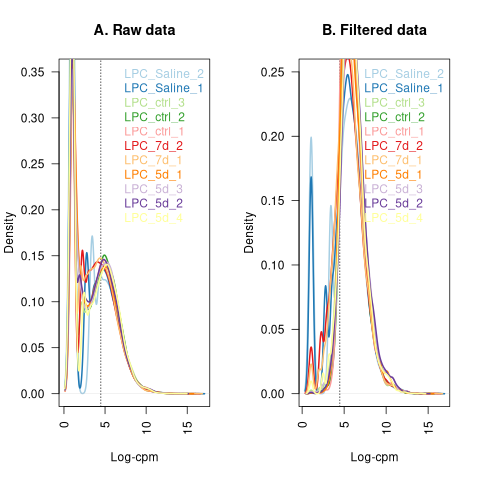

In [26]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

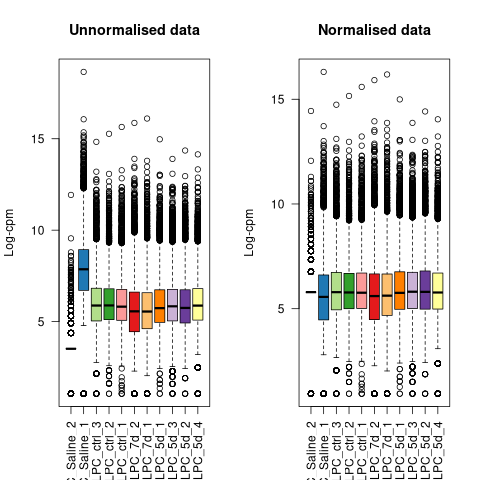

In [27]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [28]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

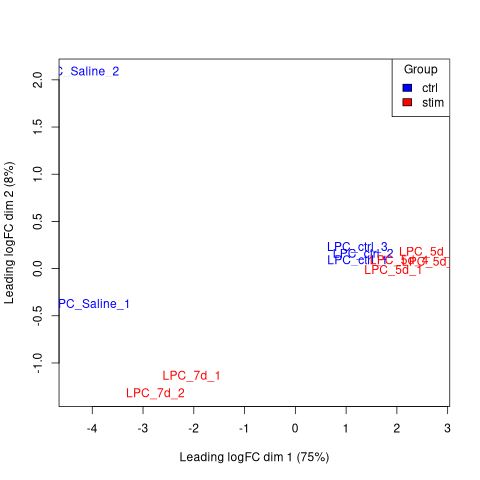

In [29]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

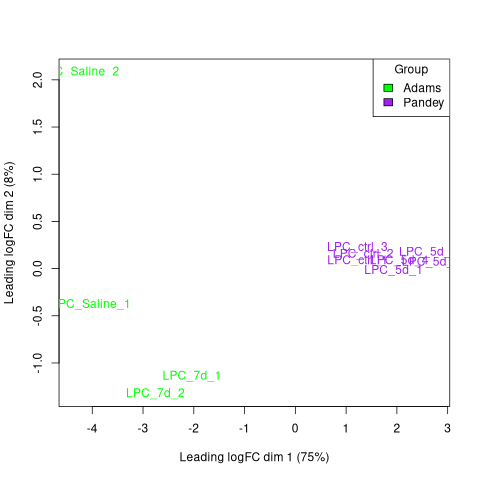

In [30]:
%%R
# Generate a numeric vector from group factors (if not already factor, convert it)
pub_factor <- as.factor(batch)
pub_colors <- as.numeric(pub_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("green", "purple")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[pub_colors])

# Adding a legend for clarity
legend("topright", legend=levels(pub_factor), fill=colors, title="Group")

In [31]:
%%R

x3$samples

             group lib.size norm.factors
LPC_Saline_2  ctrl   106806    1.0816288
LPC_Saline_1  ctrl   194837    1.0637621
LPC_ctrl_3    ctrl   422251    1.0682788
LPC_ctrl_2    ctrl  1016454    1.0518122
LPC_ctrl_1    ctrl  3899685    1.0366918
LPC_7d_2      stim   354162    1.0379994
LPC_7d_1      stim   490960    1.0299415
LPC_5d_1      stim  2106855    0.9370866
LPC_5d_3      stim  1069865    0.8840877
LPC_5d_2      stim   599606    0.8393128
LPC_5d_4      stim   282486    1.0036822


In [32]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

   cdctrl cdstim
1       1      0
2       1      0
3       1      0
4       1      0
5       1      0
6       0      1
7       0      1
8       0      1
9       0      1
10      0      1
11      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [33]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [34]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [35]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=batch) 

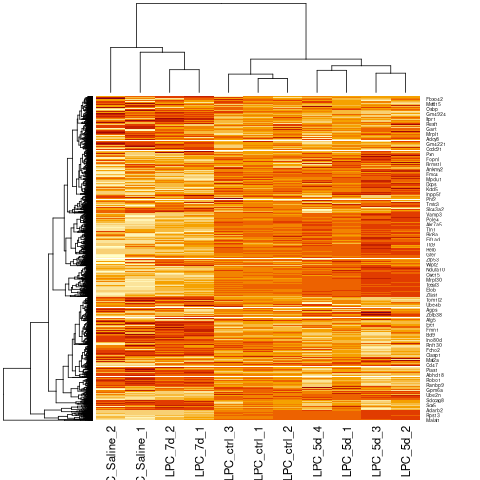

In [36]:
%%R
heatmap(logCPM)

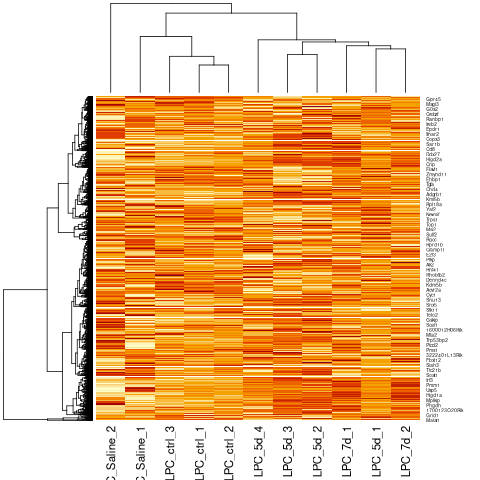

In [37]:
%%R
heatmap(logCPM_no_batch)

# Voom with quality weights

In [38]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [39]:
%%R
batch

LPC_Saline_2 LPC_Saline_1   LPC_ctrl_3   LPC_ctrl_2   LPC_ctrl_1     LPC_7d_2 
       Adams        Adams       Pandey       Pandey       Pandey        Adams 
    LPC_7d_1     LPC_5d_1     LPC_5d_3     LPC_5d_2     LPC_5d_4 
       Adams       Pandey       Pandey       Pandey       Pandey 
Levels: Adams Pandey


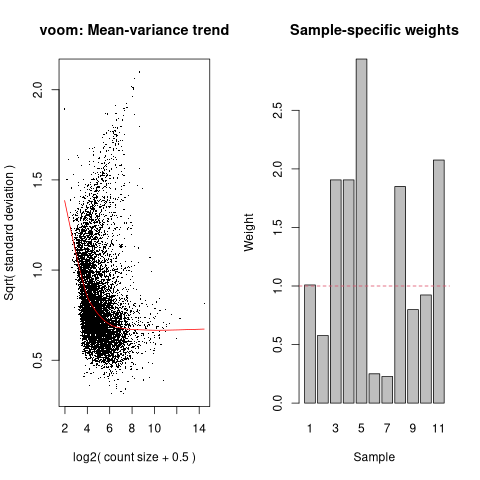

In [40]:
%%R
y <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [41]:
%%R
corfit <- duplicateCorrelation(y, design, block=batch)
corfit$consensus.correlation

[1] 0.5223754


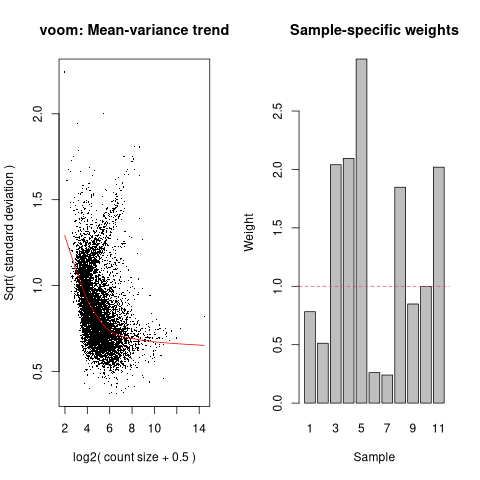

In [42]:
%%R
y2 <- voomWithQualityWeights(x2$counts, design, plot=TRUE, block=batch, correlation=corfit$consensus)

In [43]:
%%R
corfit2 <- duplicateCorrelation(y2,design,block=batch, weights=y2$targets$sample.weights)
corfit2$consensus.correlation

[1] 0.5471343


In [44]:
%%R
fit <- lmFit(y2, design, block=batch, correlation=corfit2$consensus)

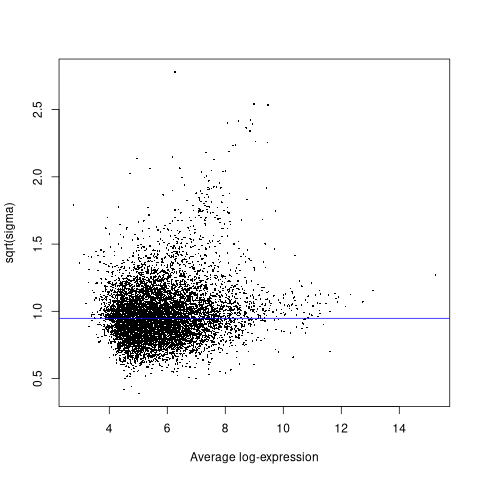

In [45]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [46]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

              logFC  AveExpr         t      P.Value    adj.P.Val        B
C4b        4.969368 5.166741  17.92496 1.262250e-11 1.019015e-07 15.94549
Serpina3n  5.016019 5.574485  16.22826 5.319566e-11 1.760439e-07 15.14196
Dbndd2     4.443583 4.783055  15.99661 6.541952e-11 1.760439e-07 14.73933
Col16a1    2.322603 5.886618  15.56691 9.670652e-11 1.951779e-07 14.77328
Unc13c    -2.726557 6.612704 -13.55744 6.896989e-10 9.751585e-07 12.69665
Josd2      3.069189 4.524543  13.50979 7.247555e-10 9.751585e-07 12.74182
Moxd1      3.612005 3.843647  12.72679 1.673460e-09 1.929978e-06 11.57496
Irgm1      2.737430 5.234113  11.89522 4.272789e-09 4.311779e-06 11.24706
Ndst3      2.129520 6.267345  11.72392 5.217632e-09 4.680216e-06 11.07084
Ermard     2.430827 6.954722  11.49149 6.868411e-09 5.544868e-06 10.81475


In [47]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 1869


In [49]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 1161


In [48]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 1, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 501


In [54]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 420
             logFC  AveExpr         t      P.Value    adj.P.Val         B
Gfap      6.727291 4.042092  7.190537 2.919006e-06 3.415238e-04  4.321374
Sv2c      5.698946 3.810591  7.253925 2.628377e-06 3.339753e-04  4.566585
Neat1     5.602056 3.535456  6.397906 1.134200e-05 8.230478e-04  3.268815
Cldn11    5.530336 3.937711  6.665799 7.100763e-06 6.763026e-04  4.003755
Clca3a1   5.511935 2.980927  7.413238 2.024103e-06 3.026034e-04  4.768050
Serpina3n 5.016019 5.574485 16.228265 5.319566e-11 1.760439e-07 15.141963


In [51]:
%%R
if ('C4b' %in% rownames(genes_up_sorted)) {
    print("C4b is in the index of genes_up_sorted")
} else {
    print("C4b is not in the index of genes_up_sorted")
}

[1] "C4b is in the index of genes_up_sorted"


In [52]:
%%R
if ('Serpina3n' %in% rownames(genes_up_sorted)) {
    print("Serpina3n is in the index of genes_up_sorted")
} else {
    print("Serpina3n is not in the index of genes_up_sorted")
}

[1] "Serpina3n is in the index of genes_up_sorted"


In [55]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 741
           logFC  AveExpr         t      P.Value    adj.P.Val         B
Mertk  -5.047232 4.781484 -5.674423 4.220420e-05 0.0017745548 1.6144697
Mef2c  -4.532872 3.978137 -5.254874 9.339406e-05 0.0028238587 1.1670206
Lyn    -4.137624 3.839774 -4.780811 2.353320e-04 0.0051065169 0.4266124
Plxdc2 -3.929185 5.010966 -5.584024 4.998419e-05 0.0019588465 2.1951791
Hapln1 -3.749670 3.470343 -6.388560 1.153089e-05 0.0008230478 2.8935136
Gas6   -3.380941 4.531941 -5.427107 6.721945e-05 0.0022517121 1.8941816


# Save output- make sure to rename!

In [56]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/LPC_demyel_OPCs_voom_wqw_REDO.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Do results overlap with LR pairs?

In [66]:
import liana as li

In [67]:
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

,ligand,receptor
31371,Dll1,Notch1
31372,Dll1,Notch2
31373,Dll1,Notch4
31374,Dll1,Notch3
31375,Nrg2,Erbb2_Erbb3


In [68]:
DEG_all = pd.read_csv('./files/LPC_demyel_OPCs_voom_wqw_REDO.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

(8073, 7)

In [69]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

(501, 7)

In [70]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 5


,ligand,receptor,logFC_ligand,logFC_receptor
3,Pros1,Mertk,1.522277,-5.047232
0,Wnt7a,Ldlr,-1.063093,-1.313553
4,Fstl5,Sdk2,-1.212869,2.413641
1,Slit1,Robo1,-1.438014,-1.249705
2,Gas6,Mertk,-3.380941,-5.047232


In [71]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

(199, 7)

In [72]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 0


,ligand,receptor,logFC_ligand,logFC_receptor


In [73]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_LPC_demyel_OPCs.csv', sep='\t', index=False)

# Check overlap

In [57]:
OPC_orig = pd.read_csv('./files/LPC_demyel_OPCs_voom_wqw_FINAL_sep.csv', index_col=None)
OPC_orig.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_orig.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_orig.shape

(8688, 7)

In [58]:
OPC_orig.head

<bound method NDFrame.head of            gene     logFC   AveExpr          t        Pvalue          Padj  \
0           C4b  4.991548  5.148658  18.088164  1.117082e-11  6.826179e-08   
1        Dbndd2  4.543842  4.764972  17.668007  1.571404e-11  6.826179e-08   
2     Serpina3n  5.026431  5.556402  16.069562  6.180884e-11  1.789984e-07   
3       Col16a1  2.324589  5.868535  15.690280  8.709132e-11  1.891623e-07   
4         Moxd1  3.784899  3.825564  14.492781  2.704537e-10  4.699404e-07   
...         ...       ...       ...        ...           ...           ...   
8683        Tro  0.000389  5.442802   0.001900  9.985087e-01  9.989687e-01   
8684      Cmss1  0.000877  7.511033   0.001461  9.988536e-01  9.991986e-01   
8685     Gtf2h2 -0.000174  5.073155  -0.000850  9.993327e-01  9.995628e-01   
8686       Wbp2  0.000148  5.527164   0.000503  9.996048e-01  9.996150e-01   
8687     Arglu1 -0.000088  8.200387  -0.000491  9.996150e-01  9.996150e-01   

              B  
0     16.503608

In [59]:
OPC_new = pd.read_csv('./files/LPC_demyel_OPCs_voom_wqw_REDO.csv', index_col=None)
OPC_new.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_new.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_new.shape

(8073, 7)

In [60]:
OPC_new.head

<bound method NDFrame.head of            gene     logFC   AveExpr          t        Pvalue          Padj  \
0           C4b  4.969368  5.166741  17.924959  1.262250e-11  1.019015e-07   
1     Serpina3n  5.016019  5.574485  16.228265  5.319566e-11  1.760439e-07   
2        Dbndd2  4.443583  4.783055  15.996605  6.541952e-11  1.760439e-07   
3       Col16a1  2.322603  5.886618  15.566910  9.670652e-11  1.951779e-07   
4        Unc13c -2.726557  6.612704 -13.557444  6.896989e-10  9.751585e-07   
...         ...       ...       ...        ...           ...           ...   
8068   Cdc42bpb -0.000486  5.589197  -0.002978  9.976631e-01  9.981576e-01   
8069      Acad9 -0.000345  4.161525  -0.001805  9.985831e-01  9.988523e-01   
8070      Cd276 -0.000305  4.531259  -0.001778  9.986048e-01  9.988523e-01   
8071        Sms -0.000180  5.967338  -0.000915  9.992815e-01  9.994053e-01   
8072    Ppp2r3d -0.000025  4.524111  -0.000114  9.999109e-01  9.999109e-01   

              B  
0     15.945492

In [61]:
# Load and process OPC_orig for upregulated and downregulated genes
OPC_orig_up = OPC_orig[(OPC_orig.logFC >= 0.7)]
OPC_orig_down = OPC_orig[(OPC_orig.logFC <= -0.7)]
print(OPC_orig_up.shape)
print(OPC_orig_down.shape)

(609, 7)
(957, 7)


In [64]:
# Load and process OPC_orig for upregulated and downregulated genes
OPC_new_up = OPC_new[(OPC_new.Padj < 0.05) & (OPC_new.logFC >= 0.7)]
OPC_new_down = OPC_new[(OPC_new.Padj < 0.05) & (OPC_new.logFC <= -0.7)]
print(OPC_new_up.shape)
print(OPC_new_down.shape)

(420, 7)
(741, 7)


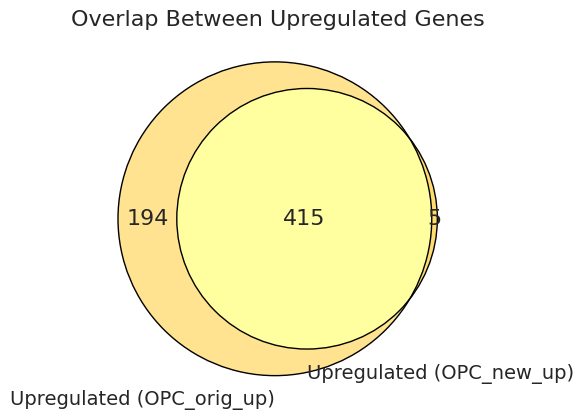

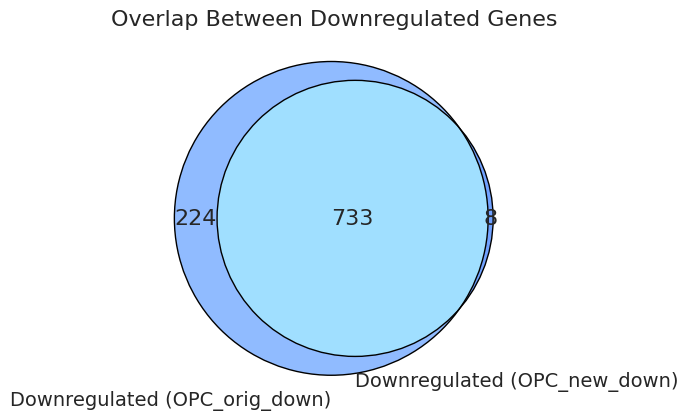

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

# Assuming you have the original and new upregulated/downregulated dataframes
# Extract sets of gene symbols for comparison
set_OPC_orig_up = set(OPC_orig_up['gene'])
set_OPC_orig_down = set(OPC_orig_down['gene'])
set_OPC_new_up = set(OPC_new_up['gene'])
set_OPC_new_down = set(OPC_new_down['gene'])

# Calculate lengths and overlap for upregulated genes
length_orig_up_only = len(set_OPC_orig_up - set_OPC_new_up)
length_new_up_only = len(set_OPC_new_up - set_OPC_orig_up)
common_up = set_OPC_orig_up & set_OPC_new_up
length_common_up = len(common_up)

# Plot Venn diagram for upregulated genes
venn_up = venn2(subsets=(length_orig_up_only, length_new_up_only, length_common_up),
                set_labels=('Upregulated (OPC_orig_up)', 'Upregulated (OPC_new_up)'),
                set_colors=('#ffdd75', '#ffd34e'),
                alpha=0.8)

venn2_circles(subsets=(length_orig_up_only, length_new_up_only, length_common_up), linewidth=1)

# Customize font sizes
for subset in venn_up.subset_labels:
    if subset:
        subset.set_fontsize(16)
for text in venn_up.set_labels:
    text.set_fontsize(14)

# Add a title and show the plot
plt.title('Overlap Between Upregulated Genes', fontsize=16)
plt.show()

# Calculate lengths and overlap for downregulated genes
length_orig_down_only = len(set_OPC_orig_down - set_OPC_new_down)
length_new_down_only = len(set_OPC_new_down - set_OPC_orig_down)
common_down = set_OPC_orig_down & set_OPC_new_down
length_common_down = len(common_down)

# Plot Venn diagram for downregulated genes
venn_down = venn2(subsets=(length_orig_down_only, length_new_down_only, length_common_down),
                  set_labels=('Downregulated (OPC_orig_down)', 'Downregulated (OPC_new_down)'),
                  set_colors=('#75aaff', '#4e8bff'),
                  alpha=0.8)

venn2_circles(subsets=(length_orig_down_only, length_new_down_only, length_common_down), linewidth=1)

# Customize font sizes
for subset in venn_down.subset_labels:
    if subset:
        subset.set_fontsize(16)
for text in venn_down.set_labels:
    text.set_fontsize(14)

# Add a title and show the plot
plt.title('Overlap Between Downregulated Genes', fontsize=16)
plt.show()